In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import astropy.time
import astropy.units as u
import astropy.constants as c

# custom_mplstyle = ("https://raw.githubusercontent.com/FoxFortino"
#                    "/DSPS_WFortino/main/custom.mplstyle")
# plt.style.use(custom_mplstyle)

In [2]:
hbl2017_csv = ("https://raw.githubusercontent.com/fedhere/DSPS_FBianco"
               "/master/HW5/hbl2017.csv")
df = pd.read_csv(hbl2017_csv)
df.head()

,#ID,x,y,σy,σx,ρxy
0,1,201,592,61,9,-0.84
1,2,244,401,25,4,0.31
2,3,47,583,38,11,0.64
3,4,287,402,15,7,-0.27
4,5,203,495,21,5,-0.33


# Exercise 1

In [3]:
def linear_fit(X, Y, sigma_y):
    A = np.vstack((np.ones_like(X), X)).T
    C = np.diag(sigma_y**2)

    C_inv = np.linalg.inv(C)
    A_T = A.T
    
    cov = np.linalg.inv(A_T @ C_inv @ A)
    b, m = cov @ (A_T @ C_inv @ Y)
    
    return b, m, cov


def linear_model(x, b, m):
    return b + m * x


def plot_data(X, Y, sigma_y, model, params, label):
    plt.errorbar(X, Y,
                 yerr=sigma_y,
                 ls="None", marker="o",
                 elinewidth=1, capsize=4)

    t = np.linspace(0, 300)
    plt.plot(t, model(t, *params), label=label)

    plt.xlabel("X")
    plt.ylabel("Y")

    plt.xlim((0, 300))
    plt.ylim((0, None))

    plt.legend(loc="upper left")

    plt.show()

In [4]:
Y = df.y.values[4:]
X = df.x.values[4:]
sigma_y = df.σy.values[4:]

b, m, cov = linear_fit(X, Y, sigma_y)
b, m, cov

(34.047727757542816,
 2.239920831631096,
 array([[ 3.32922601e+02, -1.88954491e+00],
        [-1.88954491e+00,  1.16166311e-02]]))

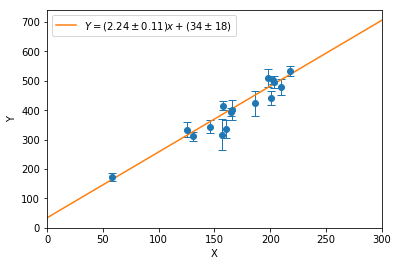

In [5]:
label = (f"$Y = ({m:.2f} \pm {np.sqrt(cov[1, 1]):.2f}) x"
            f" + ({b:.0f} \pm {np.sqrt(cov[0, 0]):.0f})$")
plot_data(X, Y, sigma_y, linear_model, (b, m), label)

### Figure 1: The least squares line of best fit (red) for the abridged data (blue) is shown. The slope of the line is 2.24 ± 0.11 and the y-intercept is 34 ± 18. The standard uncertainty variance, $\sigma_m^2$, is 332.

# Exercise 2

In [6]:
Y = df.y.values
X = df.x.values
sigma_y = df.σy.values

b, m, cov = linear_fit(X, Y, sigma_y)
b, m, cov

(213.2734919759614,
 1.0767475241683258,
 array([[ 2.07188189e+02, -1.05427206e+00],
        [-1.05427206e+00,  5.99181008e-03]]))

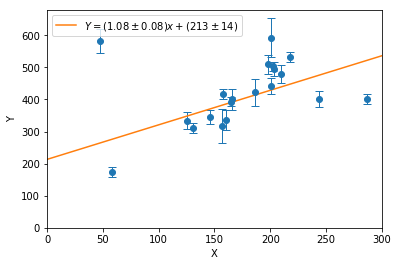

In [7]:
label = (f"$Y = ({m:.2f} \pm {np.sqrt(cov[1, 1]):.2f}) x"
            f" + ({b:.0f} \pm {np.sqrt(cov[0, 0]):.0f})$")
plot_data(X, Y, sigma_y, linear_model, (b, m), label)

### Figure 2: The least squares line of best fit (red) for the entire dataset (blue) is shown. The slope of the line is 1.08 ± 0.08 and the y-intercept is 213 ± 14. The standard uncertainty variance, $\sigma_m^2$, is 207. It is troubling now that the line of best fit intersects the uncertainty bars of only 5/20 data points. The additional data points seem to be outliers if we are assuming that this data should actually be a line with Gaussian noise.

# Exercise 3

In [8]:
def quad_fit(X, Y, sigma_y):
    A = np.vstack((np.ones_like(X), X, X**2)).T
    C = np.diag(sigma_y**2)

    C_inv = np.linalg.inv(C)
    A_T = A.T
    
    cov = np.linalg.inv(A_T @ C_inv @ A)
    b, m, q = cov @ (A_T @ C_inv @ Y)
    
    return b, m, q, cov


def quad_model(x, b, m, q):
    return b + m * x + q * x**2

In [9]:
Y = df.y.values[4:]
X = df.x.values[4:]
sigma_y = df.σy.values[4:]

b, m, q, cov = quad_fit(X, Y, sigma_y)
b, m, q, cov

(72.89462647168693,
 1.5960504522746533,
 0.0022988884081209804,
 array([[ 1.51410913e+03, -2.14671957e+01,  6.99004580e-02],
        [-2.14671957e+01,  3.36107642e-01, -1.15856956e-03],
        [ 6.99004580e-02, -1.15856956e-03,  4.13658125e-06]]))

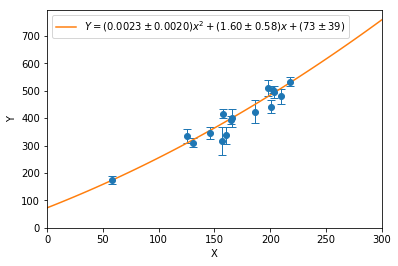

In [10]:
label = (f"$Y = "
         f"({q:.4f} \pm {np.sqrt(cov[2, 2]):.4f}) x^2 + "
         f"({m:.2f} \pm {np.sqrt(cov[1, 1]):.2f}) x + "
         f"({b:.0f} \pm {np.sqrt(cov[0, 0]):.0f})$")
plot_data(X, Y, sigma_y, quad_model, (b, m, q), label)

### Figure 3: A least squares fit of a quadratic model $q x^2 + m x + b$ (red) of the abridged data (blue) is shown. The parameters and their uncertainties are $q = 0.0023 \pm 0.0020$, $m = 1.60 \pm 0.58$, and $b = 73 \pm 39$. The standard uncertainty variance on parameter m is $\sigma_m = 0.36$.

# Exercise 4

\begin{align}
    p(t_i | \sigma_{t_i}, T) &= \frac{1}{\sqrt{2 \pi \sigma_{t_i}^2}} \exp{ \left( -\frac{1}{2} \frac{(t_i - T)^2}{\sigma_{t_i}^2} \right) } \\
    \mathcal{L} &= \prod_{i=1}^{N} p(t_i | \sigma_{t_i}, T) \\
    \mathcal{L} &= \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi \sigma_{t_i}^2}} \exp{\left( -\frac{1}{2} \frac{(t_i - T)^2}{\sigma_{t_i}^2} \right)} \\
    \ln \mathcal{L} &= \ln \prod_{i=1}^N \frac{1}{\sqrt{2 \pi}} + \ln \prod_{i=1}^N \frac{1}{\sigma_{t_i}^2} + \ln \prod_{i=1}^N \exp{\left( -\frac{1}{2} \frac{(t_i - T)^2}{\sigma_{t_i}^2} \right)} \\
    \ln \mathcal{L} &= \ln \prod_{i=1}^N \frac{1}{\sqrt{2 \pi}} + \ln \prod_{i=1}^N \frac{1}{\sigma_{t_i}^2} + \sum_{i=1}^N -\frac{1}{2} \frac{(t_i - T)^2}{\sigma_{t_i}^2} \\
    \frac{\partial \mathcal{L}}{\partial T} &= 0 \\
    0 &= \frac{\partial}{\partial T} \sum_{i=1}^N -\frac{1}{2} \frac{(t_i - T)^2}{\sigma_{t_i}^2} \\
    0 &= \sum_{i=1}^N -\frac{1}{2 \sigma_{t_i}^2} \frac{\partial}{\partial T} (t_i - T)^2 \\
    0 &= \sum_{i=1}^N -\frac{1}{2 \sigma_{t_i}^2} (-2) (t_i - T) \\
    0 &= \sum_{i=1}^N \frac{1}{\sigma_{t_i}^2}(t_i - T) \\
    \sum_{i=1}^N \frac{T}{\sigma_{t_i}^2} &= \sum_{i=1}^N \frac{t_i}{\sigma_{t_i}^2} \\
    T \sum_{i=1}^N \frac{1}{\sigma_{t_i}^2} &= \sum_{i=1}^N \frac{t_i}{\sigma_{t_i}^2} \\
    T &= \frac{\sum_{i=1}^N \frac{t_i}{\sigma_{t_i}^2}}{\sum_{i=1}^N \frac{1}{\sigma_{t_i}^2}} \qquad \square
\end{align}

---

<h1 style="color:red"> Awesome !</h1>
